# Capstone Project- Time Series Modeling Workbook
Cary Mosley, May 2020

## Import Libraries

In [1]:
import pandas as pd
import calendar, time
import datetime as dt
from datetime import date
from pandas.tseries.offsets import DateOffset
import numpy as np
import string, re 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
import pickle
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%run -i 'timeseriesfunctions.py'
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Outline
* First I will check for stationarity/unit roots using the Dickey-Fuller and if I find the time series are not stationary I will work with the data to arrive at stationarity.
* I will construct a baseline persistance model for both SPY and VIX
* I will construct ARIMAX models for both SPY and VIX seperately using senitment indicators and the NY Times sentiment analysis seperately
* I will work with my sentiment indicators to feature engineer and then build another set of ARIMAX models using this data
* I will create a VAR model using SPY and VIX together

# Stationarity

The first thing I'm going to do is check for unit roots on SPY and VIX using a Dickey Fuller test.

In [2]:
# Read in the SPY and VIX data
spy_df=pd.read_pickle('../Data/spy_df')
vix_df=pd.read_pickle('../Data/vix_df')

In [3]:
spy_df.head()

,Adj Close,Ticker
Date,,
2006-06-29,96.124527,SPY
2006-07-06,96.086758,SPY
2006-07-13,94.830073,SPY
2006-07-20,93.916246,SPY
2006-07-27,95.820935,SPY


In [4]:
#Dropping the ticker column
spy_df = spy_df['Adj Close'].to_frame()
vix_df = vix_df['Adj Close'].to_frame()

Now I will run the Dickey Fuller tests


In [5]:
spy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 723 entries, 2006-06-29 to 2020-04-30
Freq: W-THU
Data columns (total 1 columns):
Adj Close    723 non-null float64
dtypes: float64(1)
memory usage: 11.3 KB


In [6]:
#Set alpha
alpha = .05
DickeyFullerTest(spy_df['Adj Close'],alpha)

We fail to reject the null hypothesis that there is a unit root as our p-value of 0.974 is greater than our alpha of 0.05 

Dickey-Fuller test: 

Test Statistic                   0.223900
p-value                          0.973571
#Lags Used                       9.000000
Number of Observations Used    713.000000
dtype: float64


In [7]:
DickeyFullerTest(vix_df['Adj Close'],alpha)

Our p-value of 0.031 is less than our alpha of 0.05 so we reject the null hypothesis that there is a unit root. The data is stationary.

Dickey-Fuller test: 

Test Statistic                  -3.042269
p-value                          0.031131
#Lags Used                      11.000000
Number of Observations Used    711.000000
dtype: float64


The SPY data is not stationary while the VIX data already is. I'll first take the log values and then difference the SPY data and then perform the Dickey Fuller test again. Although we rejected the null that the VIX data is not stationary I will also create models that use the differenced values of VIX to see how they perform.

In [8]:

vix_diff=vix_df.diff().dropna()
vix_diff.rename(columns = {"Adj Close": 'VIX Differenced'},inplace=True)

In [9]:

spy_diff = spy_df.diff().dropna()

In [10]:
DickeyFullerTest(spy_diff['Adj Close'],alpha)

Our p-value of 0.0 is less than our alpha of 0.05 so we reject the null hypothesis that there is a unit root. The data is stationary.

Dickey-Fuller test: 

Test Statistic                -9.722162e+00
p-value                        9.480394e-17
#Lags Used                     8.000000e+00
Number of Observations Used    7.130000e+02
dtype: float64


Text(0.5, 1.0, 'Differenced SPY close over time')

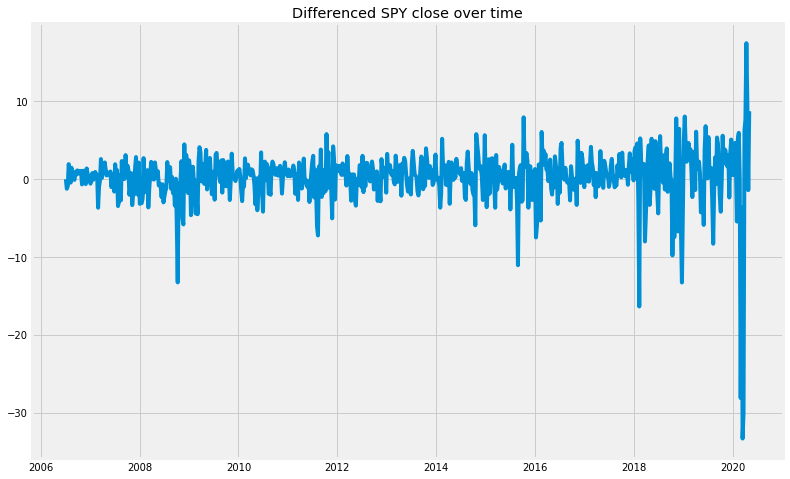

In [11]:
plt.figure(figsize=(12,8))
plt.plot(spy_diff)
plt.title('Differenced SPY close over time')

In [12]:
#Writing the differenced SPY to a pickle
spy_diff.to_pickle('../Data/spy_diff')
vix_diff.to_pickle('../Data/vix_diff')

Now that we have confirmed both our time series are stationary its time to examine the ACF and PACF plots so that we can build our baseline models.

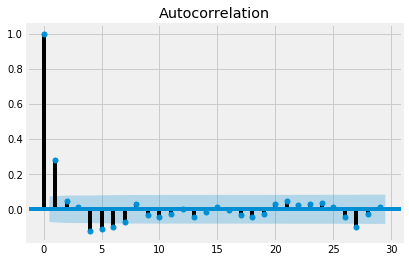

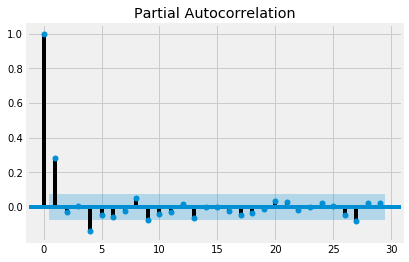

In [13]:
alpha=.05
plot_acf(spy_diff['Adj Close'], alpha=alpha);
plot_pacf(spy_diff['Adj Close'], alpha=alpha);

The autocorrelation plot tells us whether we need to add MA terms. It is clear that the first lag is significant. The PACF plot shows us also that the 1st lag is going to be useful to include as the AR term. For this first model I'll make sure to use a (1,1,1) and will try some other combinations as well. These plots also look typical for a random walk time series.

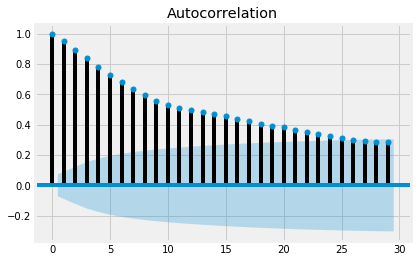

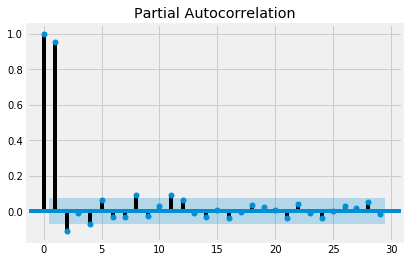

In [14]:
alpha=.05
plot_acf(vix_df['Adj Close'], alpha=alpha);
plot_pacf(vix_df['Adj Close'], alpha=alpha);

We can see from the ACF plot that there are a number of strongly positively correlated lags we can use for the moving average model. This is somewhat expected as there is a tendency for VIX to be sticky for a period of time although it does tend to mean revert to a white noise series. The PACF shows us that only the first lag is strongly correlated. Thus a (1,0,n) model is likely to be decent with n potentially being a number of variables.



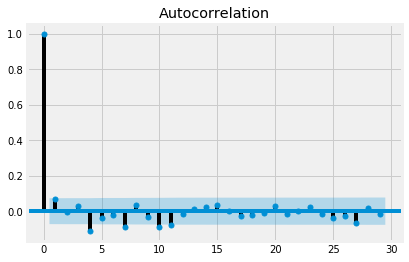

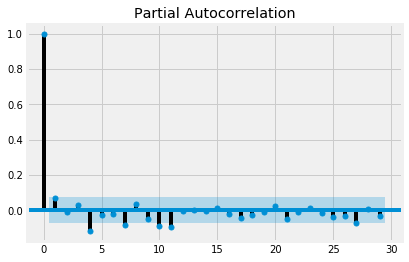

In [15]:
alpha=.05
plot_acf(vix_diff, alpha=alpha);
plot_pacf(vix_diff, alpha=alpha);

It appears that the differenced VIX has no relationship between any past observations. This is what we would expect for a random time series. Now that we have looked through these I will build a baseline model before moving on to more complete models.

# Baseline Models
For my baseline SPY and VIX models I will be using a persistance algorithm where the predicted value at the t+1 time step is the value at the t-1 time step. First I will set the train test date split I plan to use going forward, with the test data being the last year of my datset.

In [16]:
train_end = '2018-04'
test_start = '2018-05'

In [17]:
spy_baseline = pd.concat([spy_df['Adj Close'].shift(1),spy_df['Adj Close']],axis=1)
spy_baseline.columns = ['t-1', 't+1']

time_series_train_spy = spy_baseline[:train_end].values
time_series_test_spy = spy_baseline[test_start:].values
time_series_train_X_spy, time_series_train_y_spy = time_series_train_spy[:,0], time_series_train_spy[:,1] 
time_series_test_X_spy, time_series_test_y_spy = time_series_test_spy[:,0], time_series_test_spy[:,1] 

In [18]:
forecasts_spy=[]
for x in time_series_test_X_spy:
    forecast_spy = x
    forecasts_spy.append(forecast_spy)
test_rmse = np.sqrt(mean_squared_error(time_series_test_y_spy,forecasts_spy))
print('The baseline SPY model RMSE is', round(test_rmse,3))

The baseline SPY model RMSE is 6.879


In [19]:
vix_baseline = pd.concat([vix_df['Adj Close'].shift(1),vix_df['Adj Close']],axis=1)
vix_baseline.columns = ['t-1', 't+1']

time_series_train_vix = vix_baseline[:train_end].values
time_series_test_vix = vix_baseline[test_start:].values
time_series_train_X_vix, time_series_train_y_vix = time_series_train_vix[:,0], time_series_train_vix[:,1] 
time_series_test_X_vix, time_series_test_y_vix = time_series_test_vix[:,0], time_series_test_vix[:,1]

In [20]:
forecasts_vix=[]
for x in time_series_test_X_vix:
    forecast_vix = x
    forecasts_vix.append(forecast_vix)
test_rmse = np.sqrt(mean_squared_error(time_series_test_y_vix,forecasts_vix))
print('The baseline VIX model RMSE is', round(test_rmse,3))

The baseline VIX model RMSE is 4.196


Now I will calcuate RMSE for the combined model

In [21]:
error = []
length = len(forecasts_spy)
for x in range(0,length):
    error.append((time_series_test_spy[x]-forecasts_spy[x])**2 + (time_series_test_vix[x]-forecasts_vix[x])**2)
mse = sum(error)[1]/length
rmse_combined = np.sqrt(mse)
print('The baseline combined model RMSE is', round(rmse_combined,3))

The baseline combined model RMSE is 8.058


Now that I have constructed the baseline models I will move on to ARIMA and ARIMAX modeling.



# ARIMA and ARIMAX Models
This next section will begin with building and evaluating ARIMA models for SPY and VIX before expanding to include the exogenous variables.

In [22]:
AR_terms = [1,2]
MA_terms = [1,2]


ARIMA_models(spy_diff['Adj Close'],AR_terms,MA_terms).sort_values(by=['Test RMSE'])

,Order,AIC,BIC,Test RMSE
1,"(1, 0, 2)",2762.314,2784.438,6.870
2,"(2, 0, 1)",2762.283,2784.408,6.870
3,"(2, 0, 2)",2764.280,2790.830,6.870
0,"(1, 0, 1)",2760.743,2778.443,6.871


These models look almost identical so we will choose the model we expected from our ACF and PACF plots of (1,1,1). Although they are not much better than the baseline there is a slight improvement.

In [23]:
AR_terms = [1]
MA_terms = [1,2,3,4,5]
ARIMA_models(vix_df,AR_terms,MA_terms).sort_values(by=['Test RMSE'])

,Order,AIC,BIC,Test RMSE
2,"(1, 0, 3)",2959.432,2985.991,10.606
3,"(1, 0, 4)",2960.825,2991.811,10.610
4,"(1, 0, 5)",2962.794,2998.206,10.611
0,"(1, 0, 1)",2958.089,2975.795,10.613
1,"(1, 0, 2)",2960.057,2982.189,10.614


For the VIX data we can see that the (1,0,1) model performs the best although some of the higher order lags also perform very similarly. Now I will check a differenced VIX series as the baseline differenced performs better than the non differenced.

In [24]:
AR_terms = [1]
MA_terms = [1,2]
ARIMA_models(vix_diff,AR_terms,MA_terms).sort_values(by=['Test RMSE'])

Order (1, 0, 2) caused an error.


,Order,AIC,BIC,Test RMSE
0,"(1, 0, 1)",2953.082,2970.781,4.196


This is barely better than the baseline.

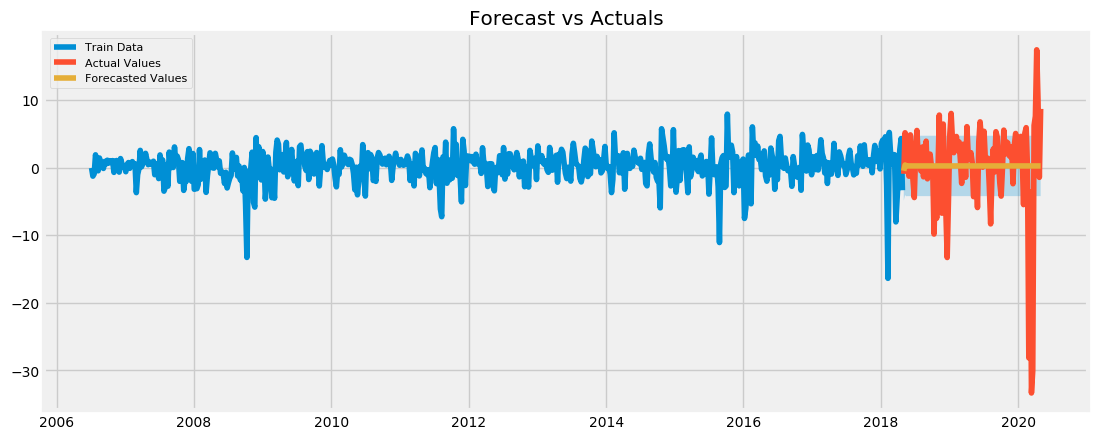

In [25]:
#Show the spy forecasts
plot_arima(spy_diff['Adj Close'],1,1)

We can see that the model is predicting essential zero change day on day which is what we would tend to expect for a random walk time series. Lets look at the summary to confirm this.

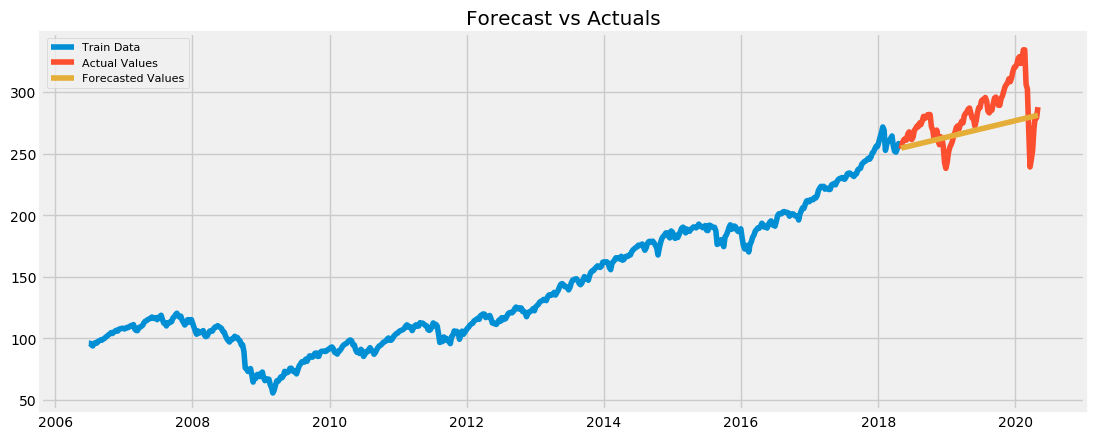

In [26]:
plot_arima_forecasts(spy_diff,spy_df,1,1)

When we look at the cumulative forecasts we do see an upwards trend which is what we expect as the SP500 exhibited a longterm positive trend over our time period with random noise for any given day.

In [27]:
arima_summary(spy_diff,1,1)

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                  617
Model:                     ARMA(1, 1)   Log Likelihood               -1376.372
Method:                       css-mle   S.D. of innovations              2.252
Date:                Fri, 22 May 2020   AIC                           2760.743
Time:                        13:34:47   BIC                           2778.443
Sample:                    07-06-2006   HQIC                          2767.624
                         - 04-26-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2564      0.102      2.507      0.012       0.056       0.457
ar.L1.Adj Close    -0.1926      0.197     -0.976      0.329      -0.579       0.194
ma.L1.Adj Close     0.3461      

Looking at the model summary we can see that the AR term is very close to 0. Essentially we are going to predict very little change in the next days value. Again, this is what we would expect from a random walk, unfortunately it doesnt make our preidcitons very useful. Finally, I'll look at a plot of the first lagged value to the original differenced for a last confirmation.

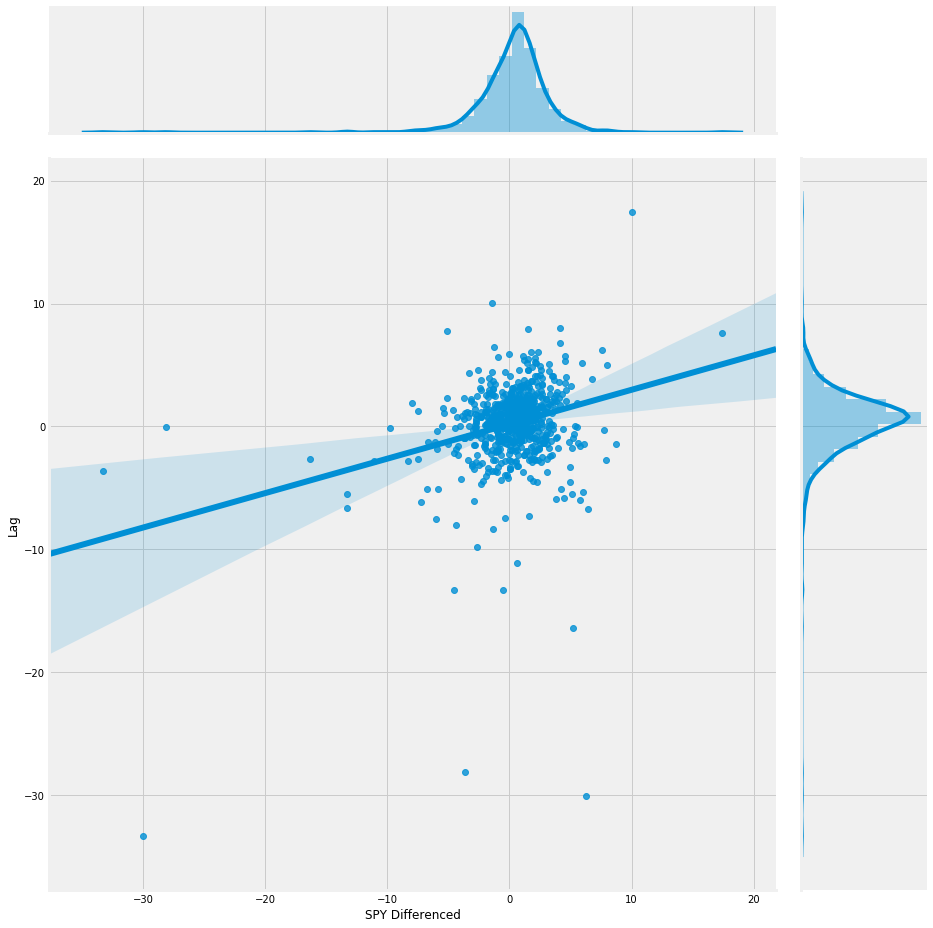

In [28]:
spy_diff.rename(columns={'Adj Close': 'SPY Differenced'},inplace=True)
spy_diff_lag = spy_diff
spy_diff_lag['Lag'] = spy_diff_lag['SPY Differenced'].shift()
sns.jointplot('SPY Differenced', 'Lag', spy_diff_lag, kind='reg', size=13)

The vast majority of the scatterplot is packed relatively evenly around 0,0. This implies that knowing the change the day before is essentially uncorrelated with the next change. This is what we woudl expect from a random walk time series. Due to this low level of impact the model is unable to predict much from the previous times values.

Now lets repeat this for VIX. We would expect a slightly different result as the future value is impacted by the previous one despite the overal series being stationary.

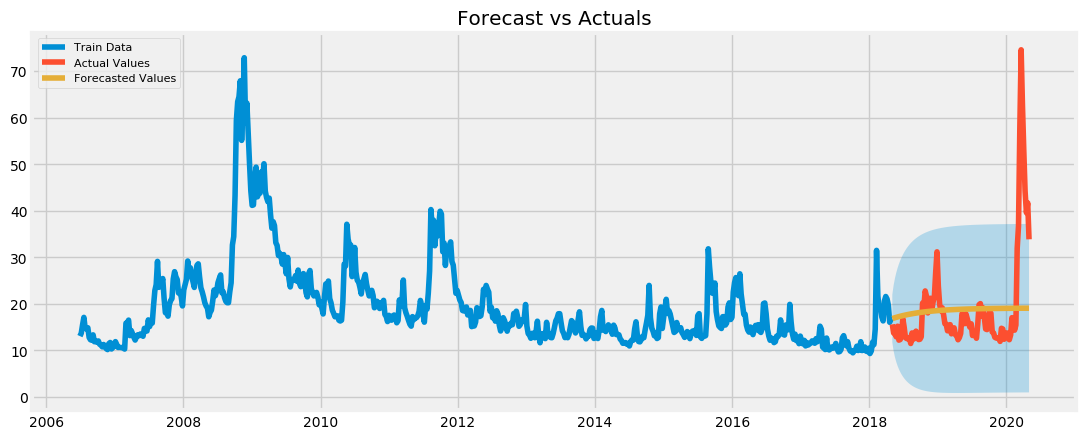

In [29]:
plot_arima(vix_df,1,1)

In [30]:
arima_summary(vix_df,1,1)

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                  618
Model:                     ARMA(1, 1)   Log Likelihood               -1475.044
Method:                       css-mle   S.D. of innovations              2.627
Date:                Fri, 22 May 2020   AIC                           2958.089
Time:                        13:34:48   BIC                           2975.795
Sample:                    06-29-2006   HQIC                          2964.972
                         - 04-26-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              19.1205      2.506      7.628      0.000      14.208      24.033
ar.L1.Adj Close     0.9600      0.011     84.330      0.000       0.938       0.982
ma.L1.Adj Close    -0.0163      

We can see that the moving average coefficient is essentially zero but the autoregressive term has quite a significant impact. This is what we would expect in that the current value in VIX is highly dependent on the previous value.

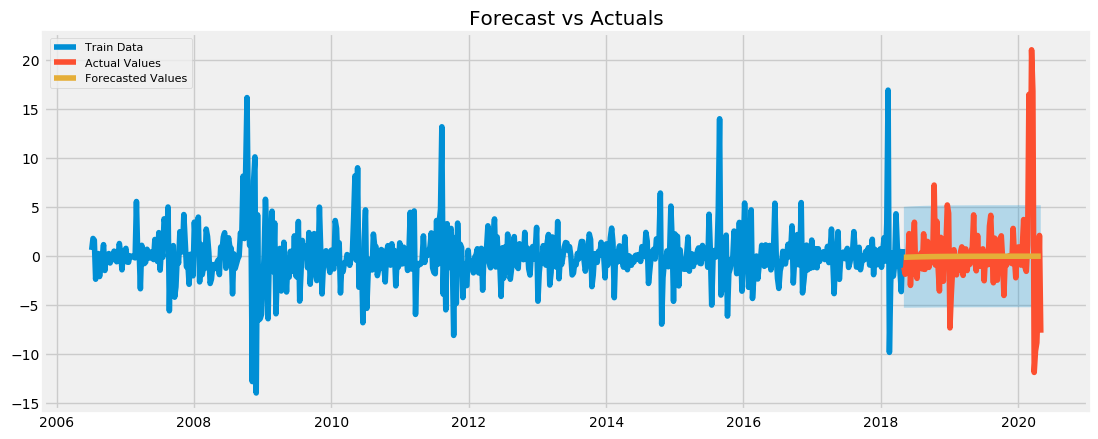

In [31]:
plot_arima(vix_diff,1,1)

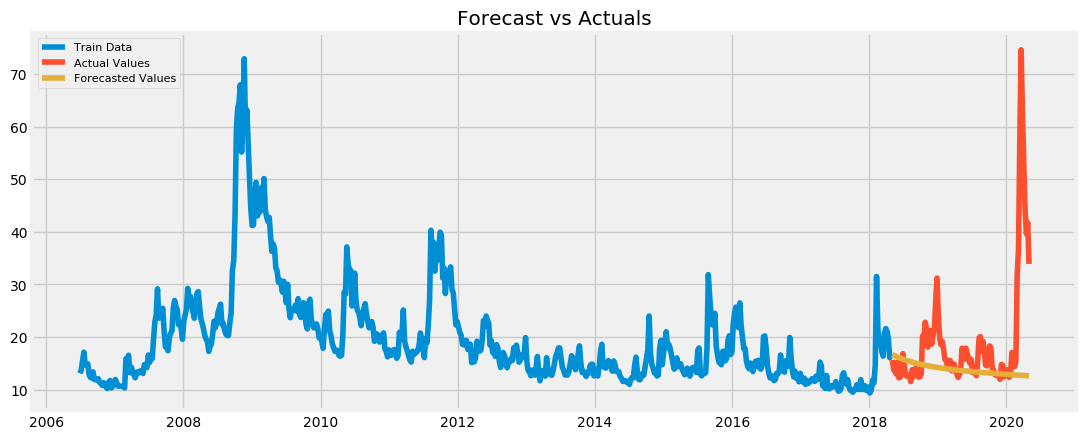

In [32]:
plot_arima_forecasts(vix_diff,vix_df,1,1)

The VIX forecasts are roughly stable around the long term mean. This model is not very good at capturing any shocks.

Now I'll move on to adding the sentiment indicators as exogenous variables!

## Adding Sentiment Indicators as an Exogenous variable

Time to add some exogenous variables!

In [33]:
nyt_df = pd.read_pickle('../Data/nyt_w_df')
sentiment_df = pd.read_pickle('../Data/sentiment_df')

We'll print the first few rows of each dataframe to refresh our memory

In [34]:
nyt_df.head()

,Headline_Blob,Snippet_Blob,Headline_VADER,Snippet_VADER
Date,,,,
2006-06-01,-0.026962,0.036882,0.003648,0.165821
2006-06-08,0.010684,0.039511,-0.012828,0.111242
2006-06-15,0.030975,0.046086,-0.018132,0.051430
2006-06-22,0.004052,0.055207,-0.016169,0.068760
2006-06-29,0.030393,0.073694,-0.031717,0.057591


In [35]:
sentiment_df.head()

,Bullish,Bearish,Spread,Mean,MaxBear,Median,MaxBull
Date,,,,,,,
2006-06-29,0.3860,0.3977,-0.0117,56.33,-125.0,65.0,125.0
2006-07-06,0.3770,0.4262,-0.0492,19.44,-100.0,20.0,100.0
2006-07-13,0.3650,0.3942,-0.0292,31.20,-50.0,25.0,150.0
2006-07-20,0.2385,0.5780,-0.3395,18.76,-100.0,25.0,100.0
2006-07-27,0.3488,0.4302,-0.0814,17.38,-50.0,15.0,100.0


First I will adjust my ARIMA_models function to include an exogenous variable.

In order to align everything I will first shift the NY Times and Sentiment Indicator Data

In [36]:
nyt_shifted=nyt_df.shift()
nyt_shifted.dropna(inplace=True)
sentiment_shifted=sentiment_df.shift()
sentiment_shifted.dropna(inplace=True)
exogenous_shifted = pd.concat([sentiment_shifted,nyt_shifted],axis=1,join='inner')

In [37]:
AR_terms = [1]
MA_terms = [1]

ARIMAX_models_single(spy_diff['SPY Differenced'],AR_terms,MA_terms,exogenous=exogenous_shifted).sort_values(by=['Test RMSE'])


,Order,AIC,BIC,Test RMSE,Exogenous
10,"(1, 0, 1)",2755.890,2778.014,6.853,Snippet_VADER
9,"(1, 0, 1)",2761.777,2783.901,6.854,Headline_VADER
0,"(1, 0, 1)",2762.600,2784.724,6.866,Bullish
2,"(1, 0, 1)",2762.672,2784.797,6.868,Spread
4,"(1, 0, 1)",2762.733,2784.857,6.869,MaxBear
1,"(1, 0, 1)",2762.734,2784.859,6.870,Bearish
3,"(1, 0, 1)",2762.740,2784.865,6.870,Mean
5,"(1, 0, 1)",2762.710,2784.835,6.870,Median
8,"(1, 0, 1)",2760.671,2782.795,6.876,Snippet_Blob
6,"(1, 0, 1)",2761.032,2783.156,6.879,MaxBull


Looking at this the sentiment indicator that provided the most improvement was using the NY Times provided snippet and the VADER sentiment analysis. Later on I'll perform some feature engineering to see if I can improve this. 

In [38]:
AR_terms = [1]
MA_terms = [1]
exogenous_df = pd.concat([sentiment_df,nyt_df],axis=1,join='inner')
ARIMAX_models_single(vix_diff,AR_terms,MA_terms,exogenous=exogenous_shifted).sort_values(by=['Test RMSE'])

Order (1, 0, 1) caused an error.


,Order,AIC,BIC,Test RMSE,Exogenous
5,"(1, 0, 1)",2958.773,2980.897,4.169,Median
3,"(1, 0, 1)",2958.340,2980.465,4.171,Mean
9,"(1, 0, 1)",2953.039,2975.164,4.181,Snippet_VADER
0,"(1, 0, 1)",2953.325,2975.450,4.186,Bullish
2,"(1, 0, 1)",2954.971,2977.095,4.192,Spread
6,"(1, 0, 1)",2954.268,2976.393,4.196,MaxBull
7,"(1, 0, 1)",2955.082,2977.206,4.196,Headline_Blob
4,"(1, 0, 1)",2954.741,2976.865,4.197,MaxBear
1,"(1, 0, 1)",2954.924,2977.048,4.199,Bearish
8,"(1, 0, 1)",2953.627,2975.751,4.209,Snippet_Blob


For VIX it looks like median active manager leverage was the best model by RMSE. 

Going forward, I'll use the median levarage and the VADER sentiment of the NY Times snippet as my exogenous variables.

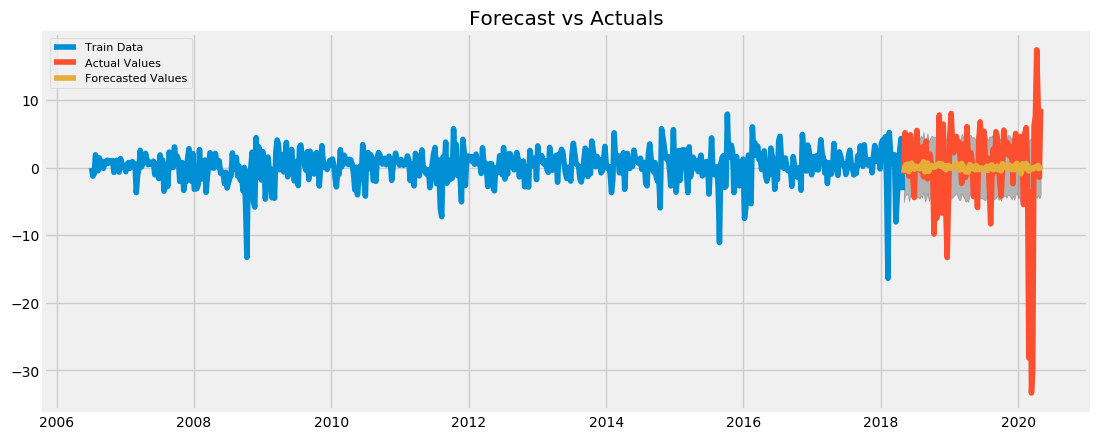

In [39]:
exog_diff=exogenous_shifted[['Snippet_VADER','Bearish','Median']]
plot_ARIMAX(spy_diff['SPY Differenced'],1,1,exog_diff)

Its clear from the graph that the model's estimates are incorporating the sentiment data but the predicted moves are still significantly smaller than the actual ones.

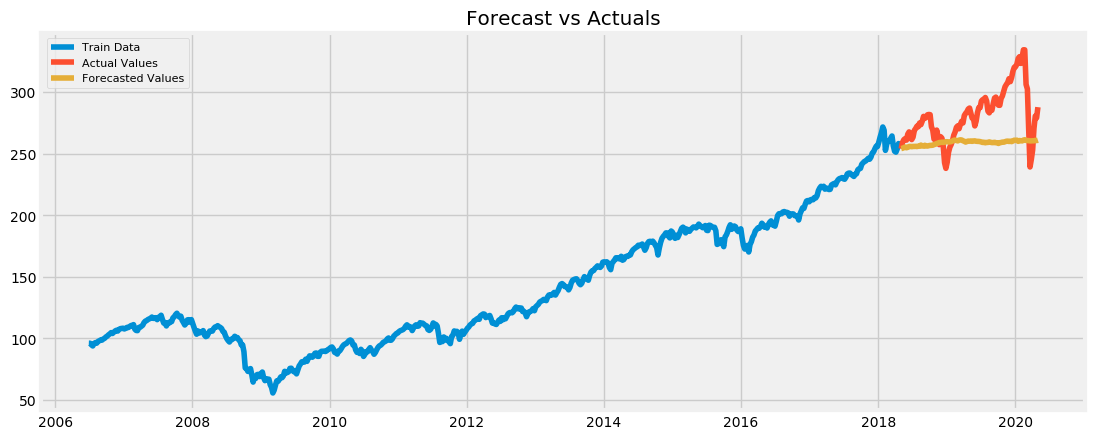

In [40]:
plot_ARIMAX_forecasts(spy_diff['SPY Differenced'],spy_df,1,1,exog_diff)

In [41]:
ARIMAX_summary(spy_diff['SPY Differenced'],1,1,exog_diff)

                              ARMA Model Results                              
Dep. Variable:        SPY Differenced   No. Observations:                  617
Model:                     ARMA(1, 1)   Log Likelihood               -1372.912
Method:                       css-mle   S.D. of innovations              2.239
Date:                Fri, 22 May 2020   AIC                           2759.825
Time:                        13:34:54   BIC                           2790.799
Sample:                    07-06-2006   HQIC                          2771.867
                         - 04-26-2018                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0189      0.680     -0.028      0.978      -1.351       1.313
Snippet_VADER             3.4308      1.311      2.618      0.009       0.862       5.999
Bearish 

Although it provided a small amount of improvement, its clear from the model summary that we could not definitely say that the coefficient for the VADER sentiment is not 0. 

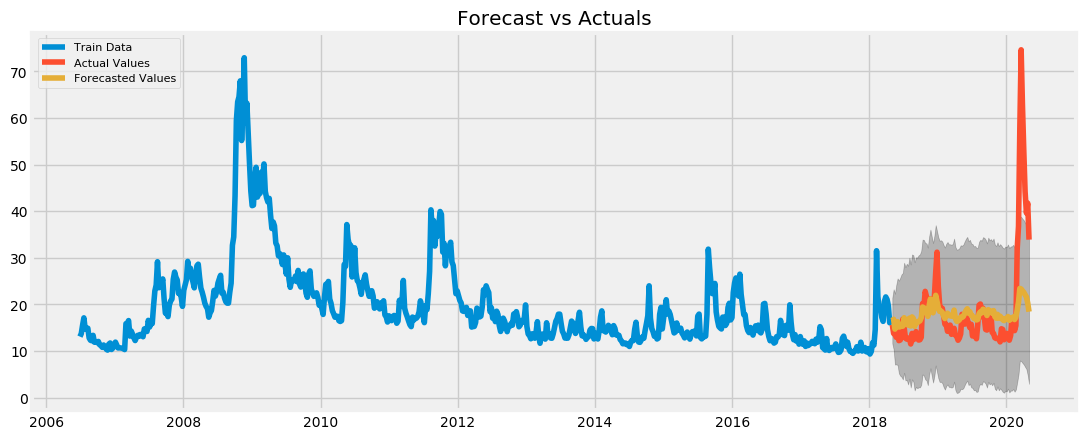

In [42]:
exog=exogenous_df[['Snippet_VADER','Median']]
plot_ARIMAX(vix_df,1,1,exog)

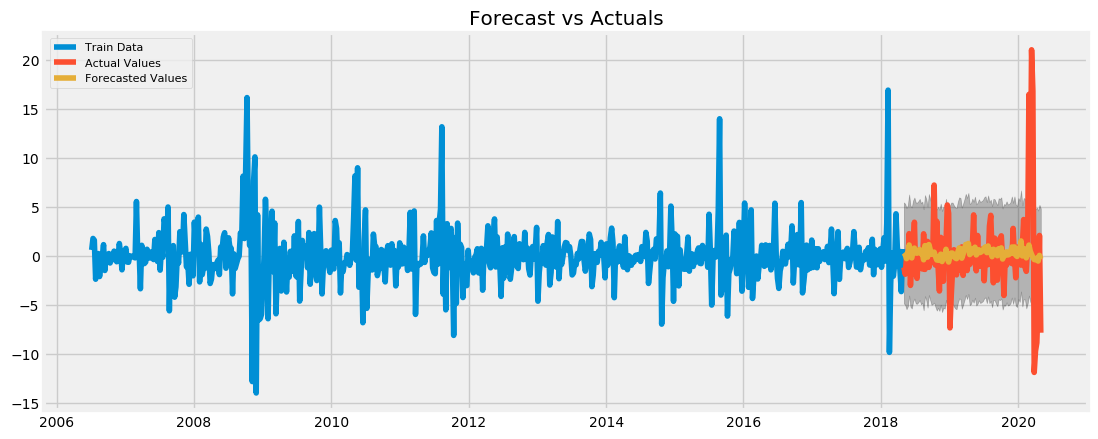

In [43]:
plot_ARIMAX(vix_diff['VIX Differenced'],1,1,exog_diff)

The forecast model looks like an improvement over the baseline and the ARIMA model! Looking at the summary below we would reject that the coefficient is 0. When there is a higher median leverage we would expect a lower value of VIX. This makes sense as VIX is known as the "fear" index.

In [44]:

ARIMAX_summary(vix_df,1,1,exog)

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                  618
Model:                     ARMA(1, 1)   Log Likelihood               -1444.160
Method:                       css-mle   S.D. of innovations              2.499
Date:                Fri, 22 May 2020   AIC                           2900.321
Time:                        13:34:55   BIC                           2926.879
Sample:                    06-29-2006   HQIC                          2910.646
                         - 04-26-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              24.0042      2.180     11.010      0.000      19.731      28.277
Snippet_VADER      -1.8969      1.172     -1.619      0.106      -4.194       0.400
Median             -0.0707      

# Feature Engineering
In this section I'll create two new features from my exogenous variables to see if I can improve my results. The features I plan to create are:

* Median Leverage * Bull-Bear Spread -If the leverage is higher and the spread is skewed Bullish this could be a positive signal
* Median Leverage * Snippet_Vader -If the leverage is higher and the sentiment is higher this could be a positive signal


In [45]:
#Create new features and add them to the exog dataframe contain the top three from ARIMA
exogenous_df['Med_and_Spread']=exogenous_df['Median']*exogenous_df['Spread']
exogenous_df['Med_and_VADER']=exogenous_df['Median']*exogenous_df['Snippet_VADER']

exog = exogenous_df[['Snippet_VADER','Median','Med_and_Spread','Med_and_VADER']]

exog.head()


,Snippet_VADER,Median,Med_and_Spread,Med_and_VADER
Date,,,,
2006-06-29,0.057591,65.0,-0.7605,3.743401
2006-07-06,0.089420,20.0,-0.9840,1.788394
2006-07-13,0.119572,25.0,-0.7300,2.989307
2006-07-20,0.168046,25.0,-8.4875,4.201147
2006-07-27,0.108139,15.0,-1.2210,1.622079


Now I'll do the same thing for the shifted exogenous data

In [46]:
#Create new features and add them to the exog dataframe contain the top three from ARIMA
exogenous_shifted['Med_and_Spread']=exogenous_shifted['Median']*exogenous_shifted['Spread']
exogenous_shifted['Med_and_VADER']=exogenous_shifted['Median']*exogenous_shifted['Snippet_VADER']

exog_diff = exogenous_shifted[['Snippet_VADER','Median','Med_and_Spread','Med_and_VADER']]

exog_diff.head()


,Snippet_VADER,Median,Med_and_Spread,Med_and_VADER
Date,,,,
2006-07-06,0.057591,65.0,-0.7605,3.743401
2006-07-13,0.089420,20.0,-0.9840,1.788394
2006-07-20,0.119572,25.0,-0.7300,2.989307
2006-07-27,0.168046,25.0,-8.4875,4.201147
2006-08-03,0.108139,15.0,-1.2210,1.622079


# Multivariate Model
In this section I'll building a combined model using VIX, SPY and by best performing exogenous features

The first thing I'm going to do is merge the differenced VIX and SPY dataframes and check for causality using Granger's test.

In [47]:
#This will create a dataframe with both spy and vix differnced and also one with spy differenced
# and vix undifferenced.
var_diff = pd.concat([spy_diff['SPY Differenced'],vix_diff],axis=1,join='inner')
var_vix = pd.concat([spy_diff['SPY Differenced'],vix_df],axis=1,join='inner')
var_df = pd.concat([spy_df['Adj Close'],vix_df],axis=1,join='inner')

In [48]:
maxlag=5
granger = grangercausalitytests(var_df,maxlag=maxlag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6756  , p=0.1959  , df_denom=719, df_num=1
ssr based chi2 test:   chi2=1.6826  , p=0.1946  , df=1
likelihood ratio test: chi2=1.6807  , p=0.1948  , df=1
parameter F test:         F=1.6756  , p=0.1959  , df_denom=719, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6546  , p=0.5199  , df_denom=716, df_num=2
ssr based chi2 test:   chi2=1.3184  , p=0.5173  , df=2
likelihood ratio test: chi2=1.3172  , p=0.5176  , df=2
parameter F test:         F=0.6546  , p=0.5199  , df_denom=716, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8848  , p=0.1307  , df_denom=713, df_num=3
ssr based chi2 test:   chi2=5.7098  , p=0.1266  , df=3
likelihood ratio test: chi2=5.6873  , p=0.1279  , df=3
parameter F test:         F=1.8848  , p=0.1307  , df_denom=713, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1248  , p=0.0761  

In [49]:
maxlag=5
granger = grangercausalitytests(var_diff,maxlag=maxlag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1540  , p=0.6949  , df_denom=718, df_num=1
ssr based chi2 test:   chi2=0.1546  , p=0.6941  , df=1
likelihood ratio test: chi2=0.1546  , p=0.6942  , df=1
parameter F test:         F=0.1540  , p=0.6949  , df_denom=718, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6006  , p=0.0749  , df_denom=715, df_num=2
ssr based chi2 test:   chi2=5.2375  , p=0.0729  , df=2
likelihood ratio test: chi2=5.2186  , p=0.0736  , df=2
parameter F test:         F=2.6006  , p=0.0749  , df_denom=715, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6090  , p=0.0506  , df_denom=712, df_num=3
ssr based chi2 test:   chi2=7.9039  , p=0.0480  , df=3
likelihood ratio test: chi2=7.8607  , p=0.0490  , df=3
parameter F test:         F=2.6090  , p=0.0506  , df_denom=712, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0926  , p=0.3591  

Although there is not clear causality, the 2nd and 3rd lags are close to the .05 threshold and even more so for the differenced series so I will move forward with the VAR model.

In [50]:

johansen(var_df)

Name   |  Test Stat > C(95%)    |   Reject Null  
 ----------------------------------------
Adj Close |  28.72 > 12.32  |   True
Adj Close |  4.68 > 4.13  |   True


These are cointegrated so we expect a long term relationship between the two variables.

In [51]:
AR_terms = [1,2,3,4]

VAR_models_single(var_diff,AR_terms,exogenous=exog_diff).sort_values(by = ['Test RMSE'])



,Lags,AIC,BIC,Test RMSE,Exogenous
2,3,2.497,2.612,5.673,Snippet_VADER
3,4,2.503,2.647,5.673,Snippet_VADER
6,3,2.496,2.611,5.673,Median
1,2,2.504,2.591,5.674,Snippet_VADER
7,4,2.506,2.651,5.676,Median
0,1,2.509,2.567,5.677,Snippet_VADER
5,2,2.497,2.584,5.679,Median
8,1,2.512,2.569,5.679,Med_and_Spread
14,3,2.501,2.616,5.680,Med_and_VADER
15,4,2.508,2.652,5.680,Med_and_VADER


In [52]:
AR_terms = [1,2,3,4]

VAR_models_single(var_vix,AR_terms,exogenous=exog_diff).sort_values(by = ['Test RMSE'])


,Lags,AIC,BIC,Test RMSE,Exogenous
11,4,2.461,2.605,8.894,Med_and_Spread
10,3,2.462,2.577,8.909,Med_and_Spread
8,1,2.447,2.504,8.917,Med_and_Spread
9,2,2.455,2.541,8.923,Med_and_Spread
4,1,2.446,2.503,8.930,Median
5,2,2.453,2.539,8.942,Median
6,3,2.461,2.576,8.958,Median
15,4,2.456,2.600,8.976,Med_and_VADER
14,3,2.459,2.574,8.986,Med_and_VADER
13,2,2.451,2.538,9.000,Med_and_VADER


The above data shows the AIC/BIC and Test RMSE based on which exogenous variable and which lag. Using the above I would choose median bullishness of active managers, which is the same that I chose for the VIX alone model and I would choose a lag of 1.

In [53]:
AR_terms = [1,2,3,4]

VAR_models_combined(var_diff,AR_terms,exogenous=exog_diff).sort_values(by = ['Test RMSE'])



,Lags,AIC,BIC,Test RMSE
0,1.0,2.497,2.597,5.658
1,2.0,2.497,2.626,5.658
2,3.0,2.494,2.652,5.658
3,4.0,2.505,2.693,5.660


In [54]:
AR_terms = [1,2,3,4]

VAR_models_combined(var_vix,AR_terms,exogenous=exog_diff).sort_values(by = ['Test RMSE'])



,Lags,AIC,BIC,Test RMSE
3,4.0,2.448,2.635,8.648
2,3.0,2.453,2.612,8.672
0,1.0,2.439,2.540,8.698
1,2.0,2.445,2.574,8.709


Using the combined exogenous variables yielded slightly worse RMSE and AIC values for the differenced data but better values for the non differenced VIX data.

In [55]:
AR_terms = [1,2]
MA_terms = [1,2]
VARMAX_models(var_diff,AR_terms,MA_terms, exogenous=exog_diff).sort_values(by = ['Test RMSE'])



,Order,AIC,BIC,Test RMSE
0,"(1, 1)",5048.714,5141.636,5.646
3,"(2, 2)",5058.146,5186.467,5.677
2,"(2, 1)",5050.611,5161.232,5.678
1,"(1, 2)",5053.205,5163.826,5.682


In [56]:
AR_terms = [1,2]
MA_terms = [1,2]
VARMAX_models(var_vix,AR_terms,MA_terms, exogenous=exog_diff).sort_values(by = ['Test RMSE'])


,Order,AIC,BIC,Test RMSE
1,"(1, 2)",5030.224,5140.846,8.514
3,"(2, 2)",5029.466,5157.788,8.592
2,"(2, 1)",5028.956,5139.577,8.632
0,"(1, 1)",5018.660,5111.582,8.648


Using a (1,1) VARMAX model I again got a slight improvement in RMSE but a significantly worse AIC.

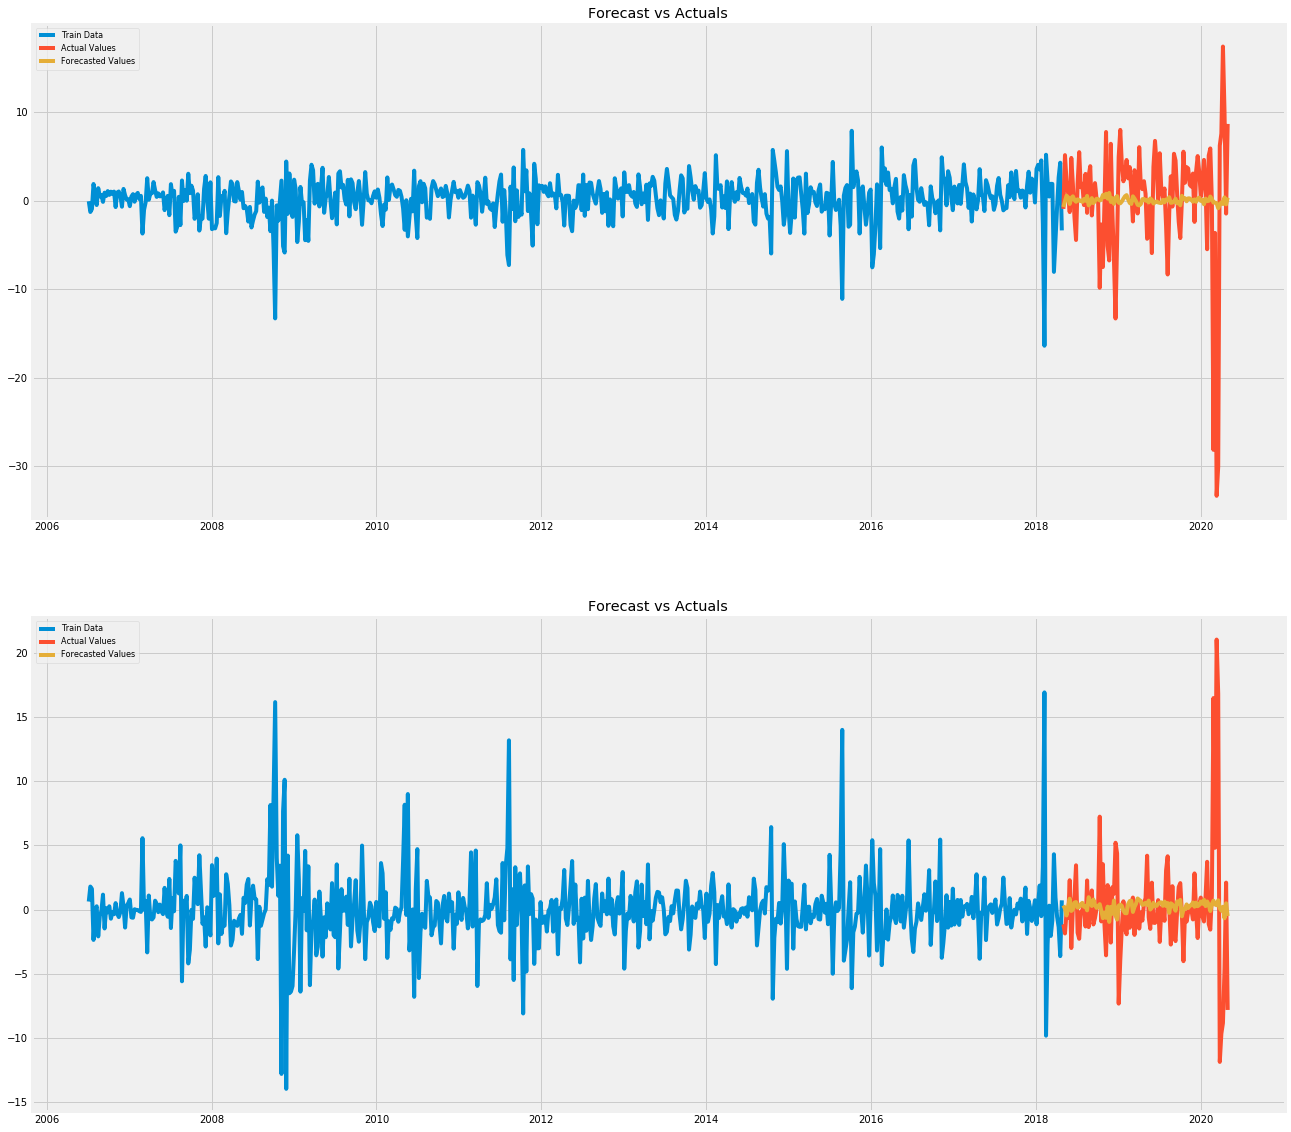

In [57]:
plot_VAR(var_diff,1,exog_diff)

Similarly to the ARIMAX models, this model significantly underestimates the movement, although it does look like an improvement using the joint model.

Now I'll repeat this with undifferenced VIX values

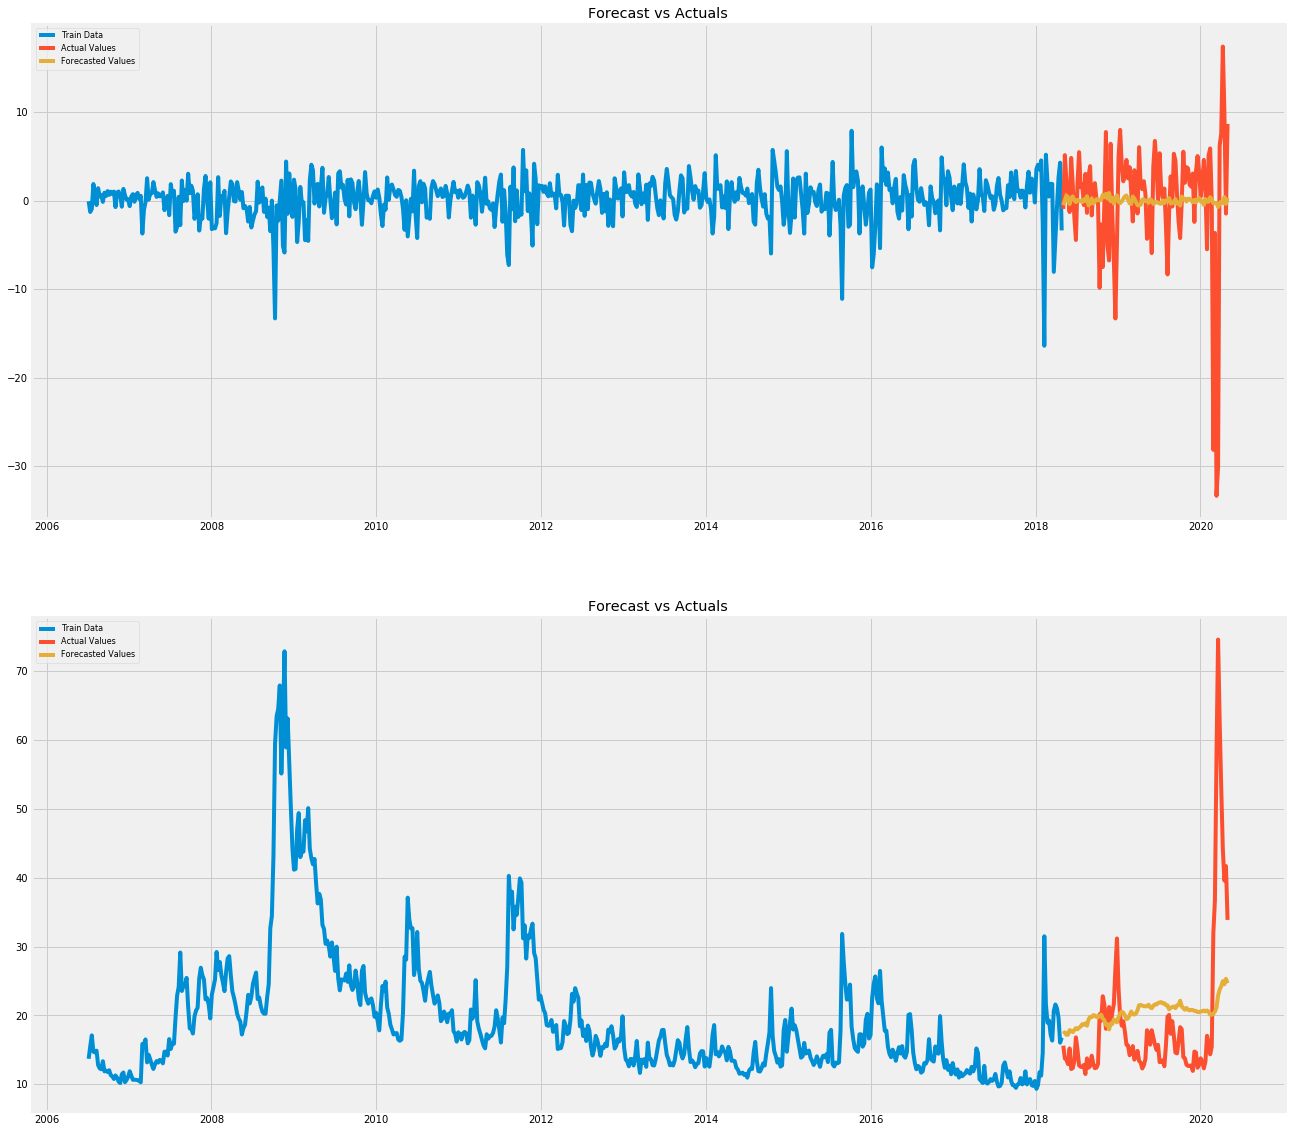

In [60]:
plot_VAR(var_vix,1,exog_diff)

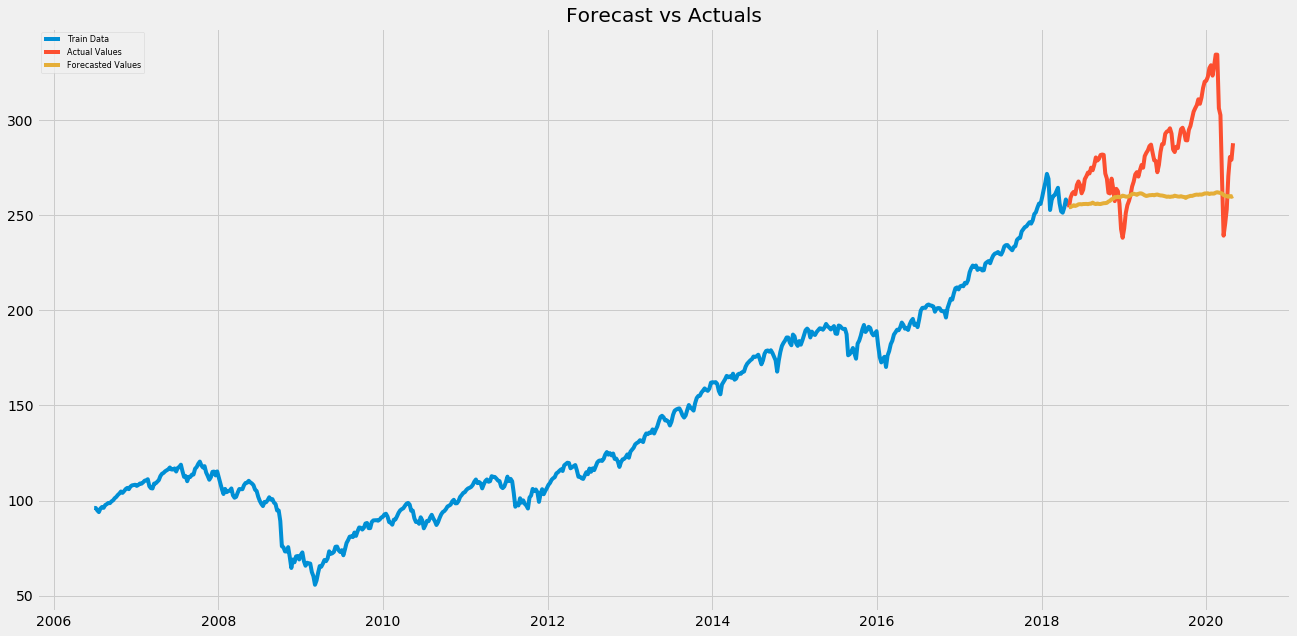

In [75]:

series= 0
lag = 1
plot_VAR_forecasts(var_diff,var_df,lag,exog_diff,series)

In [61]:
VAR_summary(var_vix,1,exog_diff)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, May, 2020
Time:                     12:06:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.53990
Nobs:                     616.000    HQIC:                   2.47846
Log likelihood:          -2485.46    FPE:                    11.4658
AIC:                      2.43937    Det(Omega_mle):         11.2096
--------------------------------------------------------------------
Results for equation SPY Differenced
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.180495         0.659892            0.274           0.784
exog0         8.681308         4.020866            2.159           0.031
exog1        -0.000142         0.005963           -0.024           0.981

Results 

In [122]:
VARMAX_summary(var_vix,1,2,exog_diff)

                                  Statespace Model Results                                  
Dep. Variable:     ['SPY Differenced', 'Adj Close']   No. Observations:                  617
Model:                                  VARMAX(1,2)   Log Likelihood               -2545.801
                                        + intercept   AIC                           5141.602
Date:                              Thu, 21 May 2020   BIC                           5252.223
Time:                                      13:02:31   HQIC                          5184.611
Sample:                                  07-06-2006                                         
                                       - 04-26-2018                                         
Covariance Type:                                opg                                         
Ljung-Box (Q):               48.80, 138.41   Jarque-Bera (JB):       981.51, 726.86
Prob(Q):                        0.16, 0.00   Prob(JB):                   0.00, 

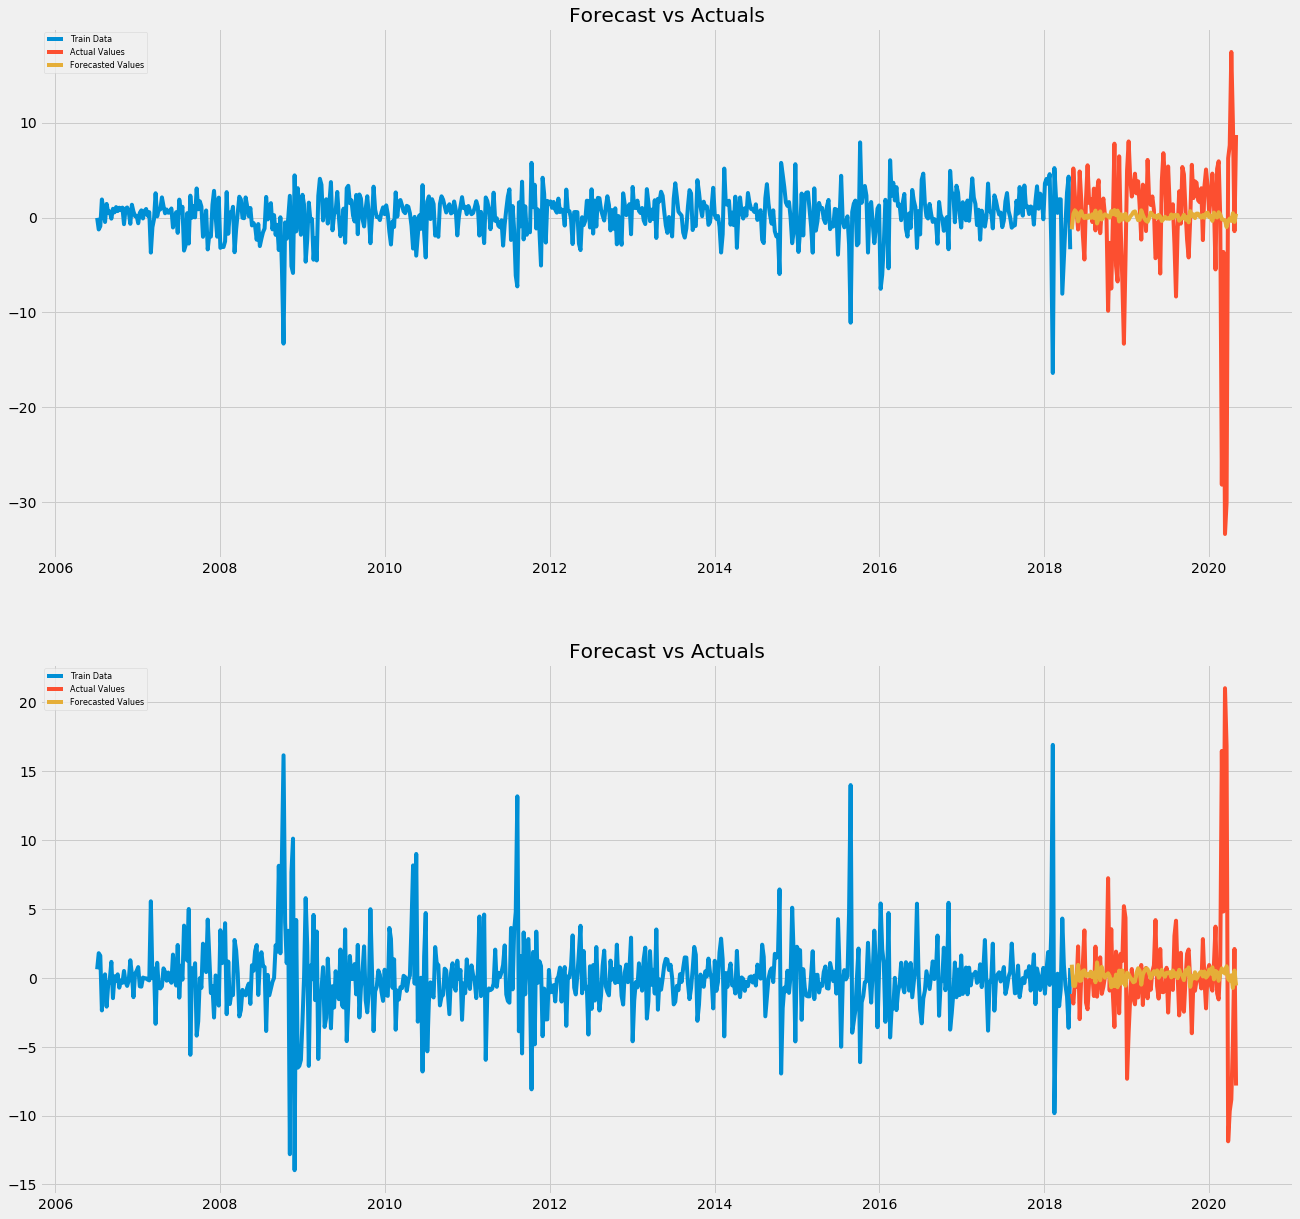

In [67]:
plot_VARMAX(var_diff,1,2,exog_diff)


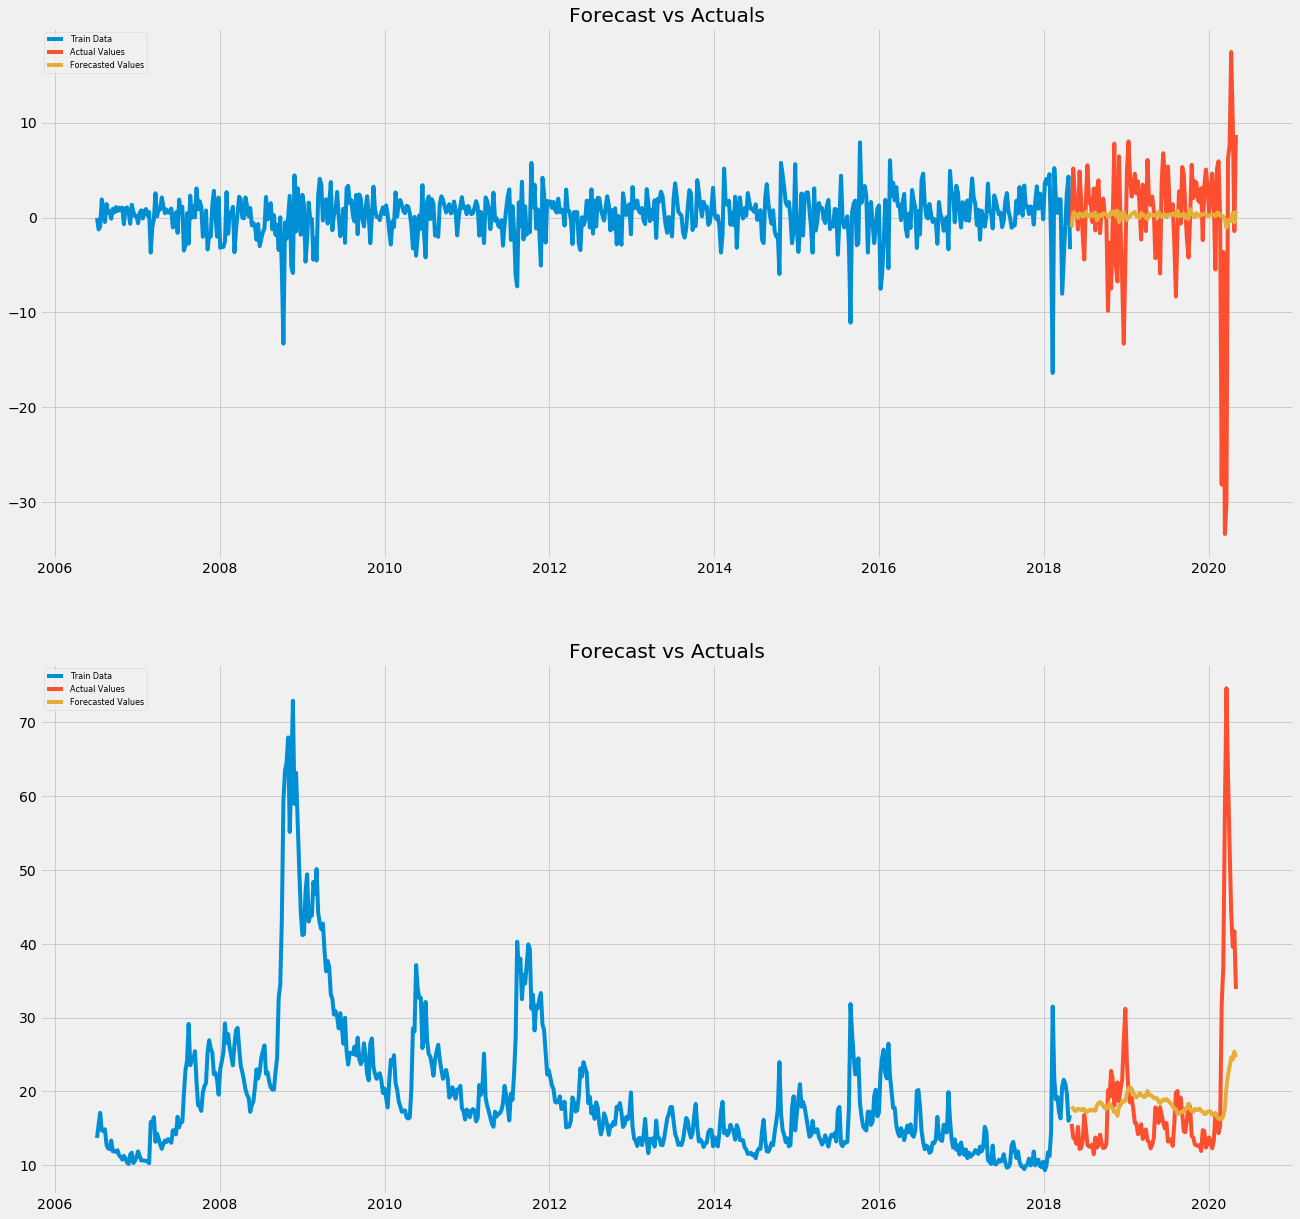

In [70]:
plot_VARMAX(var_vix,1,2,exog_diff)

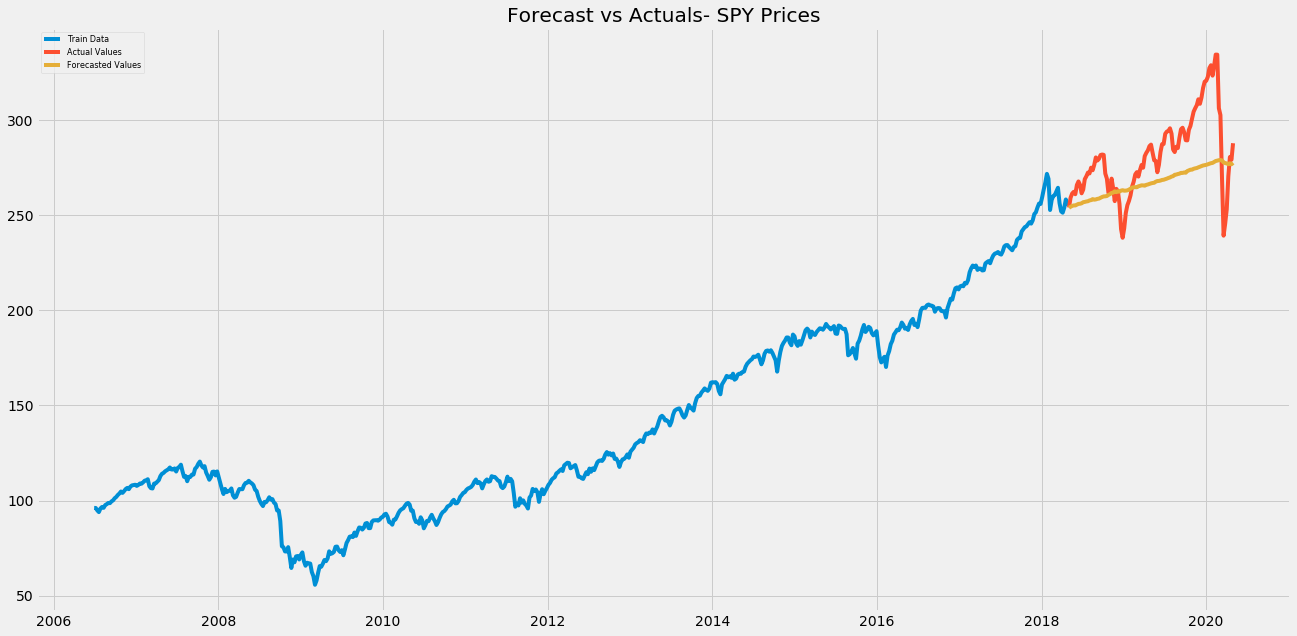

In [79]:
plot_VARMAX_forecasts(var_vix,var_df,1,2,exog_diff,series)

Based on these results the model using the differenced spy and vix values performs the best.

# LSTM Model

In this section I will create an LSTM model for both SPY and VIX seperately and then together.

## SPY LSTM Model

In [47]:
#create LSTM SPY dataframe
LSTM_spy = pd.concat((spy_df['Adj Close'],exog),axis=1,join='inner')
LSTM_spy

,Adj Close,Snippet_VADER,Median,Med_and_Spread,Med_and_VADER
Date,,,,,
2006-06-29,96.124527,0.057591,65.0,-0.760500,3.743401
2006-07-06,96.086758,0.089420,20.0,-0.984000,1.788394
2006-07-13,94.830073,0.119572,25.0,-0.730000,2.989307
2006-07-20,93.916246,0.168046,25.0,-8.487500,4.201147
2006-07-27,95.820935,0.108139,15.0,-1.221000,1.622079
...,...,...,...,...,...
2020-04-02,253.113998,-0.031870,20.5,-3.175286,-0.653335
2020-04-09,270.555000,0.071296,25.0,-2.017300,1.782407
2020-04-16,280.590009,-0.057846,35.0,-2.760800,-2.024604


In [96]:
#load values
values = LSTM_spy.values

#Scale featuers
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(values.shape)
#specify number of lags
lags = 1
n_features = 5

#convert to supervised
supervised = series_to_supervised(scaled,lags,1)

#drop columns we're not predicting
supervised.drop(supervised.columns[[-4,-3,-2,-1]], axis=1, inplace=True)
print(supervised.head())

(723, 5)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.145006   0.570401       0.65   0.391788   0.549882  0.144870
2   0.144870   0.625806       0.20   0.388764   0.514925  0.140361
3   0.140361   0.678293       0.25   0.392200   0.536398  0.137083
4   0.137083   0.762672       0.25   0.287253   0.558067  0.143916
5   0.143916   0.658390       0.15   0.385558   0.511951  0.146832


In [97]:

#take values and length of train/test set
values = supervised.values
train_length = len(spy_diff['SPY Differenced'][:train_end])



In [98]:
#split into train and test set
train = values[:train_length, :]
test = values[train_length:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(617, 1, 5) (617,) (105, 1, 5) (105,)


Train on 617 samples, validate on 105 samples
Epoch 1/30
617/617 - 1s - loss: 0.2260 - val_loss: 0.6407
Epoch 2/30
617/617 - 0s - loss: 0.1334 - val_loss: 0.5253
Epoch 3/30
617/617 - 0s - loss: 0.1257 - val_loss: 0.4721
Epoch 4/30
617/617 - 0s - loss: 0.1324 - val_loss: 0.4499
Epoch 5/30
617/617 - 0s - loss: 0.1332 - val_loss: 0.4409
Epoch 6/30
617/617 - 0s - loss: 0.1313 - val_loss: 0.4369
Epoch 7/30
617/617 - 0s - loss: 0.1281 - val_loss: 0.4337
Epoch 8/30
617/617 - 0s - loss: 0.1248 - val_loss: 0.4300
Epoch 9/30
617/617 - 0s - loss: 0.1213 - val_loss: 0.4254
Epoch 10/30
617/617 - 0s - loss: 0.1179 - val_loss: 0.4202
Epoch 11/30
617/617 - 0s - loss: 0.1145 - val_loss: 0.4138
Epoch 12/30
617/617 - 0s - loss: 0.1112 - val_loss: 0.4064
Epoch 13/30
617/617 - 0s - loss: 0.1078 - val_loss: 0.3982
Epoch 14/30
617/617 - 0s - loss: 0.1043 - val_loss: 0.3884
Epoch 15/30
617/617 - 0s - loss: 0.1007 - val_loss: 0.3769
Epoch 16/30
617/617 - 0s - loss: 0.0971 - val_loss: 0.3639
Epoch 17/30
617/617

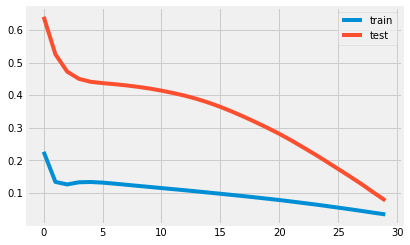

In [99]:

# design network
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [100]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], lags*n_features))

In [101]:
yhat.shape

(105, 1)

In [102]:

print(test_X)
test_X.shape

[[0.71483524 0.42224846 0.625      0.49809765 0.4521922 ]
 [0.71157945 0.51365799 0.68       0.38504069 0.51333579]
 [0.730121   0.70794999 0.625      0.46953823 0.63561496]
 [0.73801908 0.73015117 0.935      0.60566342 0.7326612 ]
 [0.74121269 0.17127321 0.9        0.5652134  0.20663542]
 [0.73667562 0.6456857  0.75       0.489987   0.6181795 ]
 [0.75409119 0.80286968 0.9        0.5507853  0.79054129]
 [0.7607507  0.50113733 0.9525     0.69944163 0.51326312]
 [0.75425212 0.34651128 0.9525     0.56359894 0.36197379]
 [0.73839187 0.545096   0.9513     0.24305515 0.55618081]
 [0.74531544 0.45023251 0.72       0.29083382 0.46821427]
 [0.76506798 0.49308656 0.91       0.57317656 0.50438486]
 [0.77056258 0.37774291 0.875      0.51720186 0.39988812]
 [0.7775123  0.62041246 0.95       0.46144601 0.6295785 ]
 [0.77581472 0.44432063 0.775      0.37098934 0.46238246]
 [0.78674843 0.90733149 0.95       0.47056582 0.90956919]
 [0.78189131 0.14432389 0.8        0.47883326 0.21519056]
 [0.7919936  0

(105, 5)

In [116]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)

In [117]:
print(inv_yhat)
inv_yhat.shape

[[0.63172811 0.42224846 0.625      0.49809765 0.4521922 ]
 [0.63266599 0.51365799 0.68       0.38504069 0.51333579]
 [0.65199286 0.70794999 0.625      0.46953823 0.63561496]
 [0.7196812  0.73015117 0.935      0.60566342 0.7326612 ]
 [0.68535787 0.17127321 0.9        0.5652134  0.20663542]
 [0.67737806 0.6456857  0.75       0.489987   0.6181795 ]
 [0.7266801  0.80286968 0.9        0.5507853  0.79054129]
 [0.73973614 0.50113733 0.9525     0.69944163 0.51326312]
 [0.71510798 0.34651128 0.9525     0.56359894 0.36197379]
 [0.68789786 0.545096   0.9513     0.24305515 0.55618081]
 [0.65728182 0.45023251 0.72       0.29083382 0.46821427]
 [0.72698218 0.49308656 0.91       0.57317656 0.50438486]
 [0.71575689 0.37774291 0.875      0.51720186 0.39988812]
 [0.74196488 0.62041246 0.95       0.46144601 0.6295785 ]
 [0.69718891 0.44432063 0.775      0.37098934 0.46238246]
 [0.76170069 0.90733149 0.95       0.47056582 0.90956919]
 [0.69672185 0.14432389 0.8        0.47883326 0.21519056]
 [0.72587794 0

(105, 5)

In [118]:
inv_yhat = scaler.inverse_transform(inv_yhat)

In [119]:

inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 24.350


array([231.78887039, 232.05028573, 237.43726934, 256.30406421,
       246.73710987, 244.51289474, 258.25486896, 261.89398322,
       255.02936744, 247.44508277, 238.9114625 , 258.3390668 ,
       255.21023994, 262.51519978, 250.03478097, 268.01616946,
       249.90459662, 258.03128283, 278.3640305 , 264.73956443,
       264.85059327, 266.92246148, 267.84990033, 266.850159  ,
       238.82370934, 238.63323416, 235.07773626, 239.04319191,
       253.29392507, 232.40445493, 216.3845039 , 232.64246168,
       241.31003759, 222.85376532, 201.11185022, 204.69653825,
       216.98407292, 231.99046008, 233.29695533, 238.87285244,
       245.67805791, 256.86349471, 250.34176748, 252.37019107,
       261.14148582, 256.32652583, 256.3011236 , 258.20748691,
       249.54670597, 263.84370808, 279.52690098, 278.68743127,
       276.71044345, 275.39173719, 270.82309077, 260.9141284 ,
       255.34554128, 244.48443561, 245.5436537 , 259.76802106,
       261.94629952, 265.81931697, 270.53431279, 281.04

In [54]:
LSTM_vixclose = pd.concat((var_vix,exog_diff),axis=1,join='inner')
LSTM_vixclose

,SPY Differenced,Adj Close,Snippet_VADER,Median,Med_and_Spread,Med_and_VADER
Date,,,,,,
2006-07-06,-0.037769,13.705000,0.057591,65.0,-0.760500,3.743401
2006-07-13,-1.256684,15.498000,0.089420,20.0,-0.984000,1.788394
2006-07-20,-0.913828,17.108000,0.119572,25.0,-0.730000,2.989307
2006-07-27,1.904689,14.744000,0.168046,25.0,-8.487500,4.201147
2006-08-03,0.812601,14.628000,0.108139,15.0,-1.221000,1.622079
...,...,...,...,...,...,...
2020-04-02,7.612000,53.078001,-0.002491,15.0,-2.875635,-0.037370
2020-04-09,17.441002,44.240000,-0.031870,20.5,-3.175286,-0.653335
2020-04-16,10.035009,39.606000,0.071296,25.0,-2.017300,1.782407


In [55]:
LSTM_vixdiff = pd.concat((var_diff,exog_diff),axis=1,join='inner')
LSTM_vixdiff

,SPY Differenced,VIX Differenced,Snippet_VADER,Median,Med_and_Spread,Med_and_VADER
Date,,,,,,
2006-07-06,-0.037769,0.625000,0.057591,65.0,-0.760500,3.743401
2006-07-13,-1.256684,1.793000,0.089420,20.0,-0.984000,1.788394
2006-07-20,-0.913828,1.610000,0.119572,25.0,-0.730000,2.989307
2006-07-27,1.904689,-2.364000,0.168046,25.0,-8.487500,4.201147
2006-08-03,0.812601,-0.116000,0.108139,15.0,-1.221000,1.622079
...,...,...,...,...,...,...
2020-04-02,7.612000,-9.671999,-0.002491,15.0,-2.875635,-0.037370
2020-04-09,17.441002,-8.838001,-0.031870,20.5,-3.175286,-0.653335
2020-04-16,10.035009,-4.634000,0.071296,25.0,-2.017300,1.782407


In [57]:
values = LSTM_vix

array([[-3.77692500e-02,  6.25000000e-01,  5.75907895e-02,
         6.50000000e+01, -7.60500000e-01,  3.74340132e+00],
       [-1.25668435e+00,  1.79300000e+00,  8.94196970e-02,
         2.00000000e+01, -9.84000000e-01,  1.78839394e+00],
       [-9.13827600e-01,  1.60999960e+00,  1.19572289e-01,
         2.50000000e+01, -7.30000000e-01,  2.98930723e+00],
       ...,
       [ 1.00350085e+01, -4.63399995e+00,  7.12962963e-02,
         2.50000000e+01, -2.01730000e+00,  1.78240741e+00],
       [-1.43400900e+00,  2.10000080e+00, -5.78458333e-02,
         3.50000000e+01, -2.76080000e+00, -2.02460417e+00],
       [ 8.69600220e+00, -7.82000020e+00,  7.60583333e-02,
         5.00000000e+01, -1.25683000e+01,  3.80291667e+00]])

# Next Steps

Now I will pickle my models and evalute using a few trading strategies in the next notebook

In [63]:
#Pickling final dataframes
#Multivariate dataframe with SPY and VIX closing values
var_df.to_pickle('../ModelPickles/var_df')
#Multivariate dataframe with SPY differenced and VIX closing values
var_vix.to_pickle('../ModelPickles/var_vix')
#Multivariate dataframe with SPY differenced and VIX differenced values
var_diff.to_pickle('../ModelPickles/var_diff')
#Univariate dataframe with SPY differenced values
spy_diff.to_pickle('../ModelPickles/spy_diff')
#Univariate dataframe with VIX differenced values
vix_diff.to_pickle('../ModelPickles/vix_diff')
#Univariate dataframe with VIX closing values
vix_df.to_pickle('../ModelPickles/vix_df')
#Univariate dataframe with SPY closing values
spy_df.to_pickle('../ModelPickles/spy_df')
#Final exogenous variables to align with differenced data
exog_diff.to_pickle('../ModelPickles/exog_diff')
#Final exogenous variables
exog.to_pickle('../ModelPickles/exog')


The models that I plan to pickle are 
* SPY differenced (1,1,1) ARIMAX model using final exogenous variables
* VIX (1,0,1) ARIMAX model using final exogenous variables
* VAR 1-lag model using SPY Differenced, VIX closing, and final exogenous variables
* VARMAX (1,1) model using SPY Differenced, VIX closing, and final exogenous variables

Creating and pickling final models

In [128]:
#SPY Model
time_series_train = spy_diff['SPY Differenced'][:train_end]
time_series_test = spy_diff['SPY Differenced'][test_start:]
exog_train = exog_diff[:train_end]
exog_test = exog_diff[test_start:]
order = (1,0,1)
         
#create model and forecasts
spy_model = ARIMA(endog = time_series_train, exog=exog_train, order=order).fit()

joblib.dump(spy_model,'spy_model.pkl')

['spy_model.pkl']

In [98]:
#VIX Model
time_series_train = vix_df[:train_end]
time_series_test = vix_df[test_start:]
exog_train_vix = exog[:train_end]
exog_test_vix = exog[test_start:]
#exog_train_vix.drop(columns = ['Med_and_Spread','Med_and_VADER'],inplace=True)
#exog_test_vix.drop(columns = ['Med_and_Spread','Med_and_VADER'],inplace=True)
order = (1,0,1)
         
vix_model = ARIMA(endog = time_series_train, exog=exog_train_vix, order=order).fit()

joblib.dump(vix_model,'vix_model.pkl')

['vix_model.pkl']

In [132]:
#VAR Model
time_series_train = var_vix[:train_end]
time_series_test = var_vix[test_start:]
exog_train = exog_diff[:train_end]
exog_test = exog_diff[test_start:]

         
var_model = VAR(endog = time_series_train, exog=exog_train).fit(1)

joblib.dump(var_model,'var_model.pkl')

['var_model.pkl']

In [133]:
#VARMAX Model
time_series_train = var_vix[:train_end]
time_series_test = var_vix[test_start:]
exog_train = exog_diff[:train_end]
exog_test = exog_diff[test_start:]
order = (1,2)
         
varmax_model = sm.tsa.VARMAX(endog = time_series_train, exog=exog_train,order=order).fit()

joblib.dump(varmax_model,'varmax_model.pkl')

['varmax_model.pkl']